In [11]:
import numpy as np
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from FreeFormDeformation import DeformationLayer
from deepali.core import functional as U
from tqdm import tqdm
import random
from diffusion_unet import Unet
from torch import nn, optim
import os
import cv2
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import torchvision.transforms.functional as F
import sys
from matplotlib import pyplot as plt

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        # Loop through training batches
        for i, (images, deformation_field) in enumerate(train_loader):
            # Move data to the device
            images = images.float().to(device)
            deformation_field = deformation_field.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, deformation_field)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

        # Compute the average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        # Loop through validation batches
        with torch.no_grad():
            for i, (images, deformation_field) in enumerate(val_loader):
                # Move validation data to the device
                images = images.float().to(device)
                deformation_field = deformation_field.to(device)
                
                outputs = model(images)
                batch_loss = criterion(outputs, deformation_field).item()
                val_loss += batch_loss
            
            # Compute the average validation loss
            avg_val_loss = val_loss / len(val_loader)
            
            # Print training and validation losses to console
            print(f'Training Loss (Epoch {epoch+1}/{n_epochs}): {avg_train_loss:.4f}')
            print(f'Validation Loss (Epoch {epoch+1}/{n_epochs}): {avg_val_loss:.4f}') 

In [4]:
def get_image_paths(root_dir): 
    
    image_paths = []
    for category in os.listdir(root_dir):
        category_dir = os.path.join(root_dir, category)
        if os.path.isdir(category_dir):
            for filename in os.listdir(category_dir):
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    image_paths.append(os.path.join(category_dir, filename))   
    return image_paths

In [5]:
def get_mean_std(images):
    mean = torch.mean(images.float())
    std = torch.std(images.float())
    return mean.item(), std.item()

In [6]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None, device = "cpu"):
        """
        Args:
            image_paths (list): List of all image Paths.
            shape: The shape of one image in the dataset.
            mean (float): The mean value for normalization.
            std (float): The standard deviation for normalization.
            transform (bool): Whether to apply the transformation.
        """
        self.image_paths = image_paths
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.image_paths)
    
    def build_deformation_layer(self, shape, device):
        """
        Build and return a new deformation layer for each call to __getitem__.
        This method returns the created deformation layer.
        """
        deformation_layer = DeformationLayer(shape)
        deformation_layer.new_deformation(device=device)
        return deformation_layer

    def __getitem__(self, idx):
        # Fetch the original image
        image_path = self.image_paths[idx]
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = Image.fromarray(img)
        transform = transforms.Resize((256,256))
        img = transform(img)
        img = F.pil_to_tensor(img).float()
        shape = img.squeeze(0).shape
        #original_image = img.unsqueeze(0)  # Add batch dimension
        original_image= img.to(self.device)
        

        # Build a new deformation layer for the current image
        deformation_layer = self.build_deformation_layer(shape, self.device).to(self.device)

        # Apply deformation to get the deformed image
        deformed_image = deformation_layer.deform(original_image)
        # Fetch the current deformation field
        deformation_field = deformation_layer.get_deformation_field().squeeze(0).to(self.device)
        
        # transform the images
        if self.transform:
            original_image = self.transform(original_image)
            deformed_image = self.transform(deformed_image)

        # Stack the original and deformed images along the channel dimension
        stacked_image = torch.cat([original_image, deformed_image], dim=0).squeeze(0)

        return stacked_image, deformation_field

In [7]:
import torch
import torch.nn.functional as f

def deform_image(deformed_image: torch.Tensor, displacement_field: torch.Tensor, device) -> torch.Tensor:
    """
    Deform a grayscale image using the given displacement field.

    Args:
        deformed_image (torch.Tensor): Grayscale image of shape (H, W).
        displacement_field (torch.Tensor): Displacement field of shape (2, H, W).

    Returns:
        torch.Tensor: Deformed image of shape (H, W).
    """
    # Ensure the input image and displacement field are on the same device
    deformed_image = deformed_image.to(device)
    displacement_field = displacement_field.to(device)
    
    # invert the displacement field
    displacement_field = -displacement_field

    # Create grid coordinates
    H, W = deformed_image.shape
    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid = torch.stack([grid_x, grid_y], dim=0).float().to(device)  # Shape: (2, H, W)

    # Add displacement field to grid
    new_grid = grid
    new_grid = new_grid.permute(1, 2, 0).unsqueeze(0)  # Shape: (1, H, W, 2)

    # Normalize grid values to be in the range [-1, 1]
    new_grid[..., 0] = 2.0 * new_grid[..., 0] / (W - 1) - 1.0
    new_grid[..., 1] = 2.0 * new_grid[..., 1] / (H - 1) - 1.0
    new_grid = new_grid + displacement_field.permute(1, 2, 0).unsqueeze(0)

    # Interpolate original image using the new grid
    deformed_image = deformed_image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    deformed_image = f.grid_sample(deformed_image, new_grid, mode='bilinear', padding_mode='border')

    return deformed_image.squeeze(0).squeeze(0)

In [8]:
def calculate_mean_std_from_batches(data_loader, num_batches=10):
    mean = 0.0
    std = 0.0
    total_images = 0

    # Calculate mean
    for i, (images, _) in enumerate(data_loader):
        if i >= num_batches:
            break
        images = images.float()
        batch_samples = images.size(0)  # batch size
        total_images += batch_samples
        mean += images.mean([0, 2, 3]) * batch_samples

    mean /= total_images

    # Calculate standard deviation
    sum_of_squared_diff = 0.0
    for i, (images, _) in enumerate(data_loader):
        if i >= num_batches:
            break
        images = images.float()
        batch_samples = images.size(0)
        sum_of_squared_diff += ((images - mean.view(1, -1, 1, 1)) ** 2).sum([0, 2, 3])

    std = torch.sqrt(sum_of_squared_diff / (total_images * images.shape[2] * images.shape[3]))

    return mean.tolist(), std.tolist()

    

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data_path = 'C:/Users/linus/Downloads/archive/afhq/train'
val_data_path = 'C:/Users/linus/Downloads/archive/afhq/val'

train_images_paths = get_image_paths(train_data_path)
val_images_paths = get_image_paths(val_data_path)
    
mean = 113.0
std = 61.0
    
#train_dataset_unnorm = CustomDataset(train_images_paths, transform=None, device=device)
#val_dataset_unnorm = CustomDataset(val_images_paths, transform=None, device=device)
    
#train_loader_unnorm = DataLoader(train_dataset_unnorm, batch_size=16, shuffle=True)
#val_loader_unnorm = DataLoader(val_dataset_unnorm, batch_size=16, shuffle=True)
    
#mean, std = calculate_mean_std_from_batches(train_loader_unnorm, num_batches=5)
#print(mean, std)
    
train_dataset = CustomDataset(train_images_paths, transform=transforms.Compose([transforms.Normalize(mean=[mean], std=[std])]), device=device)
val_dataset = CustomDataset(val_images_paths, transform=transforms.Compose([transforms.Normalize(mean=[mean], std=[std])]), device=device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = Unet(
        dim=8,
        init_dim=None,
        out_dim=2,
        dim_mults=(1, 2, 4, 8),
        channels=2,
        resnet_block_groups=8,
        learned_variance=False,
        conditional_dimensions=0,
        patch_size=1,
        attention_layer=None
    )

model.to(device)
# Check if weights file exists
if os.path.isfile('/vol/aimspace/projects/practical_SoSe24/registration_group/model_weights/model_weights_afhq.pth'):
    model.load_state_dict(torch.load('/vol/aimspace/projects/practical_SoSe24/registration_group/model_weights/model_weights_afhq.pth', map_location=device))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=1e-5)

n_epochs = 5
#train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device)
    
# save (update the number of epochs in name)
   
#torch.save(model.state_dict(), '/vol/aimspace/projects/practical_SoSe24/registration_group/model_weights/model_weights_afhq.pth')


Attention lvl 0 8 8
Attention lvl 1 8 16
Attention lvl 2 16 32
Attention lvl 3 32 64


d:\Dokumente\03_RCI\practical\Folder_structure\.conda\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\Dokumente\03_RCI\practical\Folder_structure\.conda\Lib\site-packages\torch\nn\functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


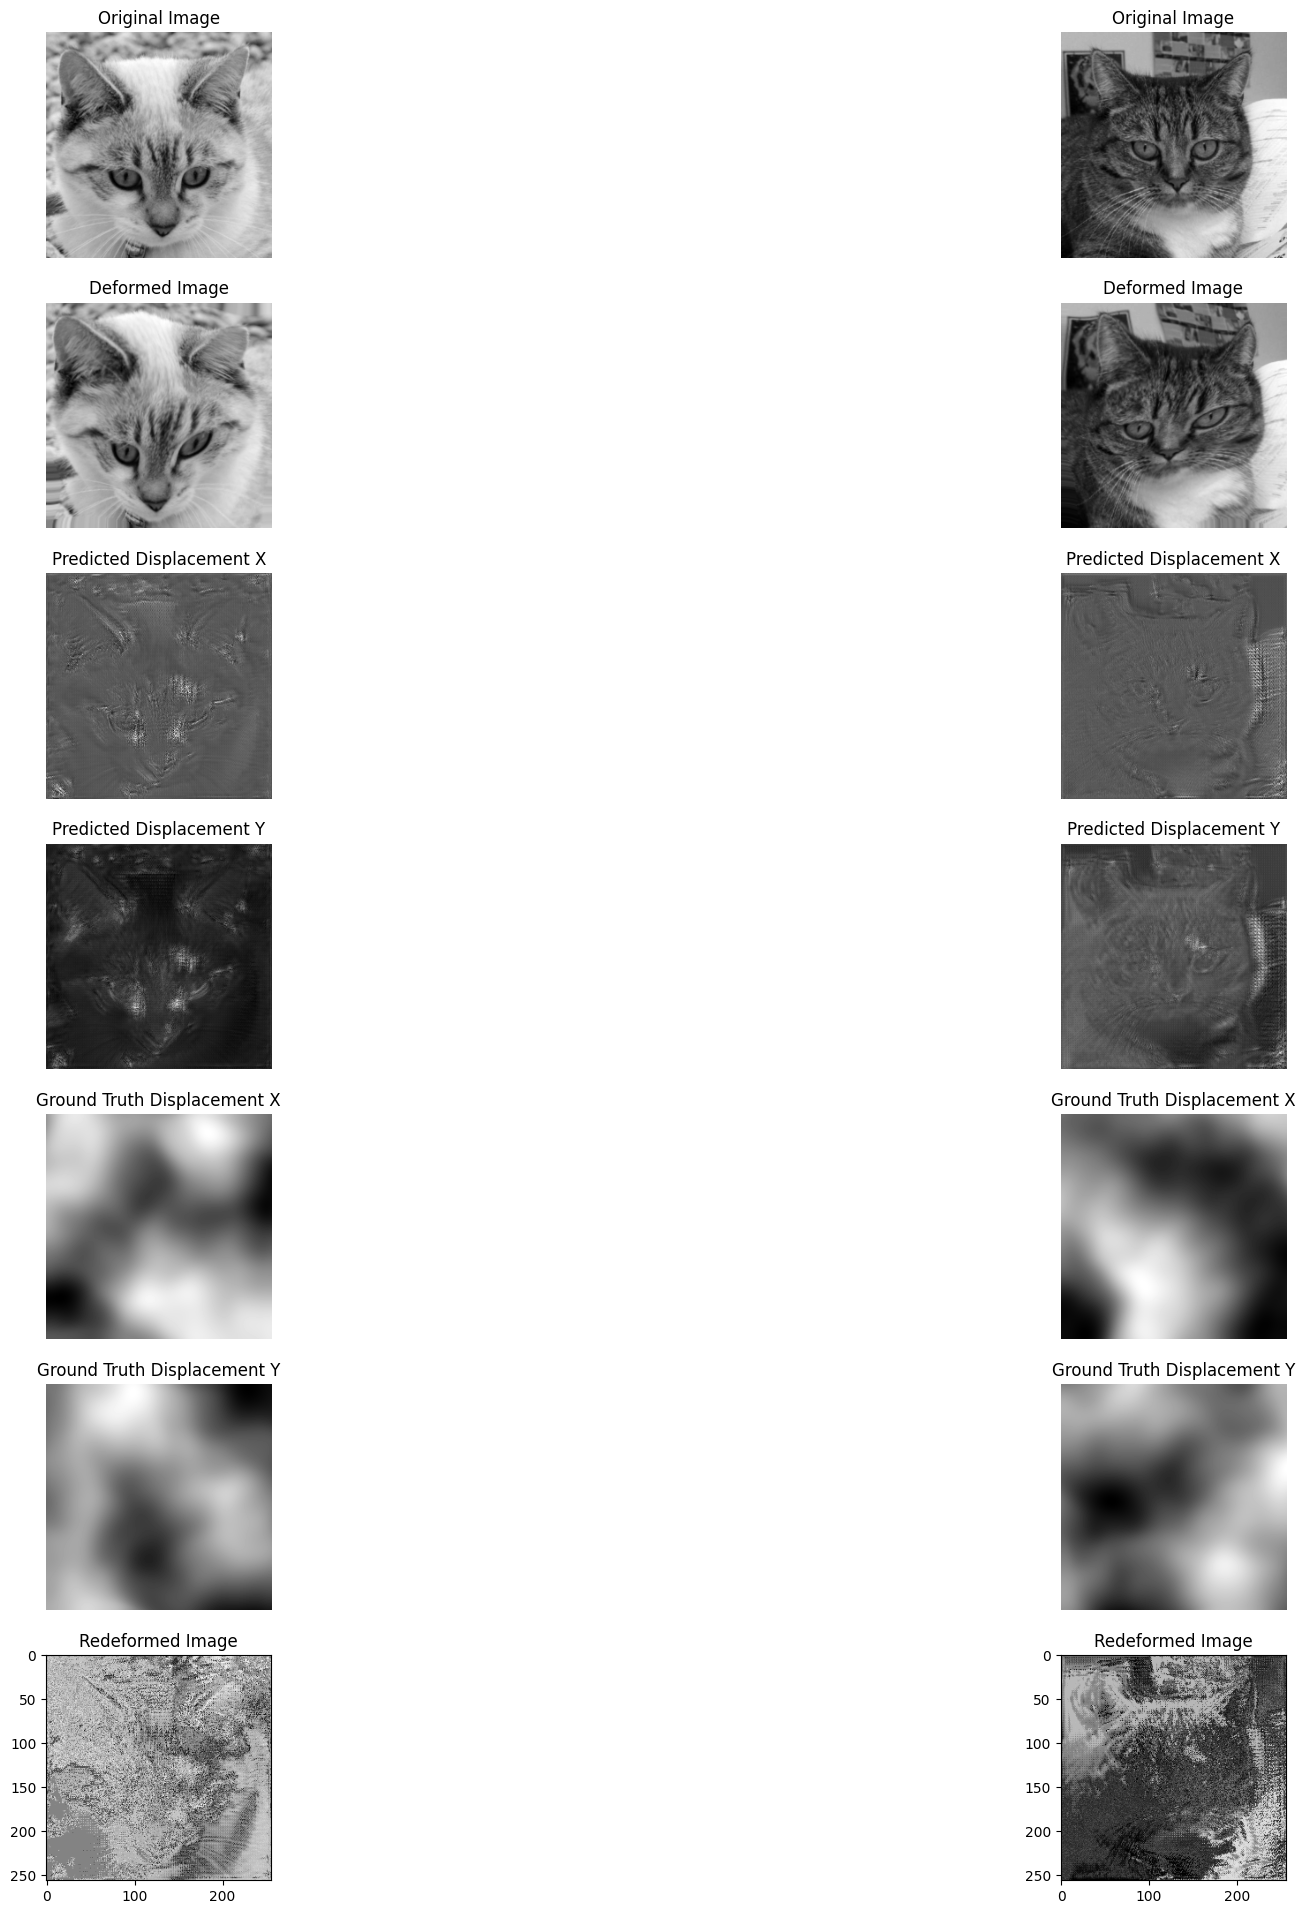

In [12]:
num_samples = 2
model.eval()
with torch.no_grad():
        images, deformation_fields = next(iter(val_loader))
        # Move data to the device
        images = images.float().to(device)
        deformation_fields = deformation_fields.to(device)
    
        outputs = model(images)
    
        # Plot the original and deformed images
        fig, axes = plt.subplots(7, num_samples, figsize=(24, 24))
        for i in range(num_samples):

            ax = axes[0, i] # [0, i]
            ax.imshow(images[i, 0].numpy(), cmap='gray')
            ax.title.set_text('Original Image')
            ax.axis('off')

            ax = axes[1, i] # [1, i]
            ax.imshow(images[i, 1].numpy(), cmap='gray')
            ax.title.set_text('Deformed Image')
            ax.axis('off')

            ax = axes[2, i] # [2, i]
            ax.imshow(outputs[i, 0].numpy(), cmap='gray')
            ax.title.set_text('Predicted Displacement X')
            ax.axis('off')
        
            ax = axes[3, i]      
            ax.imshow(outputs[i, 1].numpy(), cmap='gray')
            ax.title.set_text('Predicted Displacement Y')
            ax.axis('off')
        
            ax = axes[4, i]
            ax.imshow(deformation_fields[i, 0].numpy(), cmap='gray')
            ax.title.set_text('Ground Truth Displacement X')
            ax.axis('off')
        
            ax = axes[5, i]
            ax.imshow(deformation_fields[i, 1].numpy(), cmap='gray')
            ax.title.set_text('Ground Truth Displacement Y')
            ax.axis('off')        
        
            inverse_transformed_image = deform_image(images[i, 1], outputs[i], device)
            #print(inverse_transformed_image.shape)
            ax = axes[6, i]
            ax.imshow(inverse_transformed_image, cmap='gray')
            ax.title.set_text('Redeformed Image')